# Unet - Constructed from the main CNN encoder and Decoder

This notebook shows how to use the CNN encoder and decoder network, glueing them 
together such that an Unet architecture emerges

In [1]:
import sys
sys.path.append('../../Shared_Resources/Shared_Scripts')
sys.path.append('./utils')


from utils_unet_from_encoder_decoder import UNet
from utils_dataset_handling import *
from utils_segmentation_training import *
from utils_save_and_load_model import *

## Download the data set

In [2]:
data_save_dir = '../../Shared_Resources/Shared_Data/'

In [3]:
# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(data_save_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(data_save_dir, 'OxfordPets', 'test')

In [4]:
target_types = 'segmentation'
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", 
                                                target_types=target_types, download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", 
                                                target_types=target_types, download=True)

## Preprocess the data

In [5]:
image_size = 32

In [6]:
common_transform = T.Compose([
        ToDevice(get_device()),
        T.Resize((image_size,image_size), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ])

post_transform = T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ])

In [7]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=common_transform,
    post_transform=post_transform,
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

In [8]:
# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=12,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=6,
    shuffle=True,
)

In [9]:
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([12, 3, 32, 32]), torch.Size([12, 1, 32, 32]))

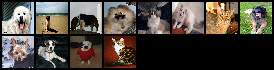

In [10]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

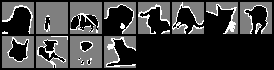

In [11]:
# Let's inspect the segmentation masks corresponding to the images above.
#
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

### Training functions

In [12]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path,print_every=2):
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        if i%print_every==0 or (epoch == epoch_j-1):
            with torch.inference_mode():
                # Display the plt in the final training epoch.
                print_test_dataset_masks(model, test_inputs, test_targets, 
                                         epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

        if scheduler is not None:
            scheduler.step()

### Initialize Unet model

In [13]:
dimension_specification =   {0: {'width_encoder': 15, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                 'width_decoder': 20, 'depth_decoder': 2, 'kernel_size_decoder': 3, 'width_skip': 15},
                            1: {'width_encoder': 30, 'depth_encoder': 1, 'kernel_size_encoder': 3, 
                                'width_decoder': 30, 'depth_decoder': 1, 'kernel_size_decoder': 3, 'width_skip': 30}
                            }

In [14]:
config = {'in_ch': 3,
         'out_ch': 3,
         'n_decoders': 1,
          'output_groupname_to_n_channels': {'object_mask': 3},
          'output_groupname_to_name_to_idx': {'object_mask': {'background': 1,'border': 2,'object': 0}},
          'dimension_specification': dimension_specification,
          'efficiency_optimized': True,
            }

In [15]:
unet = UNet(**config)

In [16]:
print_model_parameters(unet)

The Model has 0.07M parameters


### Train Unet

In [17]:
n_epochs=10

lr = 1e-3

In [18]:
# Optimizer and Learning Rate Scheduler.
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

In [19]:
train_loop(unet, pets_train_loader, (test_pets_inputs, test_pets_targets), (0, n_epochs), 
                           optimizer, scheduler, save_path=None)

Epoch: 00, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6676
Epoch: 00, Accuracy[Pixel: 0.7734, IoU: 0.5751, Custom IoU: 0.5280]
Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.5570
Epoch: 02, Learning Rate: 0.001


KeyboardInterrupt: 